In [4]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

Assume the detector count happens in the pixel in which the x-ray is absorbed. 

The X-ray attenuation in silicon follows:

$I(l) = I_0 \exp(-\mu l)$

where l is the path length and $\mu$ absorption factor.

Absortion length is its inverse
$s = 1/\mu$

The path traveled before absorbtion is:

$l = -s  \log(rnd)$

where $rnd$ is a random number

In [5]:
import numpy as np
import numpy.ma as ma
from collections import Counter
from scipy.spatial.transform import Rotation as R
import scipy.signal as signal

# all plotting choices
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Detector info

In [6]:
# pixel depth 
D = 1 # mm

# pixel size
px_x = 0.172 #mm
px_y = 0.172 #mm

# detector normal
det_normal = np.array([-0.00186461, 0.00883524, -0.99995923])

# absorption factor
mu = 0.6245476712834831 # mm^-1
# absorption length
s = 1/mu
s

1.6011588001680317

Use spots from real data as front of detector signal

# Projection code

In [7]:
# pixel coordinates in detector frame in mm
pixel_coords = np.load('pixel_coords.npy')
pixel1_coords = pixel_coords[pixel_coords[:,2] == 7 ].reshape(7,7,3)[:,:,:2]

# s1 vectors for all pixels
s1_vector = np.load('s1_vectors.npy')
s1_vector1 = s1_vector[:49].reshape(7,7,3)
s1_vector2 = s1_vector[49:98].reshape(7,7,3)
s1_vector3 = s1_vector[98:].reshape(7,7,3)

# intensity on each pixel
pixel_array = np.load('pixel_array.npy')                        
pixel_array1, pixel_array2, pixel_array3 = pixel_array.astype(np.int8)

Pad all arrays 

In [8]:
def pad_2Darray(array, pad):
    return np.pad(array, ((pad,pad), (pad,pad)), 
                          'constant', constant_values=0)

def pad_3Darray(array, pad):
    '''
    pad every slice in 3D array
    '''
    return np.pad(array, ((pad,pad), (pad,pad), (0,0)), 
                          'constant', constant_values=0)

In [9]:
padding = 4

Define pixel positions in padded area

In [10]:
def position_grid(num_pix, px_x, px_y, s1_map):
    '''
    make a grid for pixel positions which will be used as s1 origin.
    If s1_map is 1 then the pixel position is its center
    Else, grid s1_map x s1_map every pixel
    '''
    px_pos_x, px_pos_y = np.meshgrid(np.arange(px_x/(2*s1_map),
                                               px_x*num_pix,
                                               px_x/s1_map),
                                    np.arange(px_y/(2*s1_map),
                                              px_y*num_pix,
                                              px_y/s1_map))
    
    px_pos_z = np.zeros((num_pix*s1_map,
                         num_pix*s1_map))
    
    # numpy arrays have axis y before x: v[y,x]
    px_pos = np.stack((px_pos_y, px_pos_x, px_pos_z)).T
    return px_pos

In [27]:
def lab_to_detector(vector, det_normal):
    '''
    From lab to detector there is a pi rotation around x
    plus a slight detector tilt
    '''
    r_flipped = R.from_rotvec(np.pi * np.array([1, 0, 0]))
    
    z_lab = np.array([0,0,1])
    v = np.cross(z_lab, det_normal)
    v_mat = np.array([[   0,  -v[2],  v[1]],
                      [ v[2],   0, -v[0]],
                      [-v[1], v[0],    0]])
    
    c = z_lab.dot(det_normal)
    
    r = R.from_matrix(np.eye(3) + v_mat + v_mat*v_mat/(1+c))
    
    return r_flipped.apply(r.apply(vector))

In [12]:
# number of MC runs per intensity per pixel
numMC = 1000

Some plotting functions

In [13]:
def plot_path_length_dist(s):
    plt.hist(s)
    plt.title('distribution of path travelled')
    plt.xlabel('distance [mm]')
    plt.ylabel('counts')
    plt.show()
    
def plot_view_in_det_frame(intensity_2D_array, pad, title):
    fig = px.imshow(intensity_2D_array, title=title, zmin=0)
    # add padding box
    pad_edge = pad-0.5
    fig.add_scatter(x=[pad_edge,pad_edge+7,pad_edge+7,pad_edge,  pad_edge], 
                    y=[pad_edge,pad_edge,  pad_edge+7,pad_edge+7,pad_edge], 
                  mode='lines')
    fig.show()

    
def plot_vector_in_det_frame(s1_array):    
    V = np.array([[s1_array[0,0]], [s1_array[0, 1]]])
    origin = np.array([[0],[0]]) # origin point
    plt.quiver(*origin, V[0]*10, -V[1]*10, scale=21)
    plt.gca().invert_yaxis()
    plt.title('s1 vector in detector frame')
    plt.show('png')

In [14]:
def map_mm_to_px(position_array, px_x, px_y):
    '''
    position_array : ndarray, size=(3,n)
    '''
    index_x = ((position_array.T[0])//px_x).astype(int)
    index_y = ((position_array.T[1])//px_y).astype(int)

    pixels = list(zip(index_x, index_y))
    return pixels

In [15]:
def match_to_px_grid(array, s1_map):
    return np.repeat(np.repeat(array, s1_map, axis=0), s1_map, axis=1)

In [28]:
def project_probability(s1_vectors, intensity, px_size, padding, num_MC, s1_map=1):
    """
    Given information about incident spot on detector
    return the probability distribution on the back of the detector
    
    Parameters
    ----------
    s1_vectors : ndarray 
                2D array of s1 vectors

    intensity : ndarray 
                2D array of pixel intensities
            
    px_size : tuple 
            Pixel size
    
    padding : int
            Padding used around spot
            
    numMC : int
            Number of Monte Carlo runs per intensity per pixel
    
    s1_map : int, optional, default 1
            Edge size of grid of s1 vectors over one pixel
            
    Returns
    -------
    norm_counts : ndarray
            Normalised (with numMC) counts per pixel
    """
    
    int_padded = pad_2Darray(intensity, padding)
    s1_padded = pad_3Darray(s1_vectors, padding)
    
    num_pix = len(int_padded)
    px_pos = position_grid(num_pix, *px_size, s1_map)
    
    num_pos = len(px_pos)
    # if s1_map>1 repeat the s1 and int array such that they match px_pos
    int_matched = match_to_px_grid(int_padded, s1_map)
    s1_matched = match_to_px_grid(s1_padded, s1_map)
    
    # ravel all array to shape = (padded_area_length + padded_area_height, quantity_dimensions)
    int_flat = int_matched.ravel()
    total_length = len(int_flat)
    s1_flat = s1_matched.reshape(total_length,3)
    px_pos_flat = px_pos.reshape(total_length,3)

    # convert s1 vectors from lab to detector frame
    s1_det_flat = lab_to_detector(s1_flat, det_normal)
    
    # mask zeros in spot region
    int_nonzero = ma.masked_values(int_flat, 0)

    summed_int = int(np.sum(int_nonzero))
    # summed_int x num_MC array of random numbers
    rnd = np.random.rand(summed_int*num_MC)
    
    # summed_int x num_MC array of random paths traveled
    l = -s * np.log(rnd)
    
    # keep data just in non-zero region
    int_valid_region = int_nonzero[~int_nonzero.mask]
    s1_valid_region = s1_det_flat[~int_nonzero.mask]
    pos_valid_region = px_pos_flat[~int_nonzero.mask]


    s1_per_hit = np.repeat(s1_valid_region, int_valid_region,axis=0)
    s1_per_MC = np.repeat(s1_per_hit, num_MC,axis=0)

    final_pos = s1_per_MC.T * l


    pos_per_hit = np.repeat(pos_valid_region, int_valid_region, axis=0)
    pos_per_MC = np.repeat(pos_per_hit, num_MC, axis=0)
    coords = pos_per_MC + final_pos.T

    # ignore x-rays that escape through the back of detector
    escaping_zplus = ma.masked_greater(coords[:,2], D)

    #ignore x-rays that travel outside padded region
    escaping_xplus = ma.masked_greater(coords[:,0], px_size[0]*num_pix)
    escaping_xminus = ma.masked_less_equal(coords[:,0], 0)
    escaping_yplus = ma.masked_greater(coords[:,1], px_size[1]*num_pix)
    escaping_yminus = ma.masked_less_equal(coords[:,1], 0)
    
    # if escaped mask away
    escaping_mask = escaping_xminus.mask | \
                    escaping_xplus.mask | \
                    escaping_yminus.mask | \
                    escaping_yplus.mask | \
                    escaping_zplus.mask
    
    indices = map_mm_to_px(coords[~escaping_mask], *px_size)
  
    
    # count hits per pixel
    c = Counter(indices)
    key_x, key_y = zip(*c.keys())
    
    counts_on_back = np.zeros((num_pix,num_pix))
    # populate count array with counts
    counts_on_back[[key_x],[key_y]] = list(c.values())    

    #counts_on_back[counts_on_back==0] =np.nan
    
    # plot some things
    plot_view_in_det_frame(int_padded.reshape(num_pix,num_pix), 
                           padding,
                           'on the front of the detector')
    plot_view_in_det_frame(counts_on_back.T/(num_MC*s1_map*s1_map),
                           padding,
                           'at the back of the detector')

    #plot_vector_in_det_frame(s1_valid_region)
    #plot_path_length_dist(final_pos[2][final_pos[2]<=D])
    det_efficiency = np.sum(counts_on_back)/summed_int/(num_MC)
  
    return counts_on_back/(num_MC*s1_map*s1_map), det_efficiency

Spot 1

In [30]:
# x-ray in the center of pixel
counts, eff = project_probability(s1_vector1, pixel_array1, (px_x, px_y), padding, numMC,1)
print('efficiency', eff)
print('this should be the same as')

efficiency 0.5373688524590163
this should be the same as


In [31]:
# grid of 4x4 xrays positions per pixel
# this will get very big very fast
counts4, eff4 = project_probability(s1_vector2, pixel_array2, (px_x, px_y), padding, numMC,4)
print('efficiency', eff4)

efficiency 0.5364623059866963


## one pixel only

In [32]:
one_pixel_spot = np.zeros((7, 7)).astype(int)
one_pixel_spot[3,3] = 1

s1_array_test = np.zeros((7,7,3))
#s1_array_test[3,3] = np.array([0.20742, 0.55121, -0.80817])
s1_array_test[3,3] = np.array([np.mean(s1_vector2[:,:,0]), np.mean(s1_vector2[:,:,1]), np.mean(s1_vector2[:,:,2])])

one_px_out_1, _ = project_probability(s1_array_test, one_pixel_spot, (px_x, px_y), padding, numMC,1)
one_px_out_10, _ = project_probability(s1_array_test, one_pixel_spot, (px_x, px_y), padding, numMC,10)

Using multiple positions over a grid over a single pixel as opposed to using a single position in the center of the pixel
gives us more information about the point spread function. Basically, using only one position is similarly
to using too few bins for a histogram


In [33]:
img_sequence = [one_px_out_1.T, one_px_out_10.T]
fig = px.imshow(np.array(img_sequence), facet_col=0)
num_pos = [1,10]
for i, num in enumerate(num_pos):
    fig.layout.annotations[i]['text'] = 'num positions = %d' %num
fig.show()


# 2D convolution

Use this as a point spread function or dispersion. Normalise it

In [36]:
disp = np.nan_to_num(one_px_out_10.T)

disp=disp/np.sum(disp)

The modelled out spot is equivalent* to convolving the original spot with the point spread function

*as long as we compute an accurate enough detector efficiency from the model

<IPython.core.display.Javascript object>


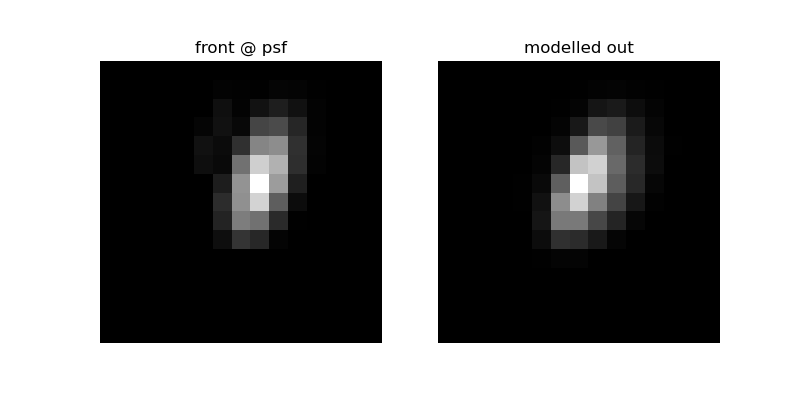

In [37]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

image_conv = conv2(pixel_array1/np.amax(pixel_array1), disp, 'full')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.gray()

ax[0].imshow(image_conv[3:-3, 3:-3], interpolation='none')
ax[0].set_title('front @ psf')
ax[0].axis('off')

ax[1].imshow(counts4.T/np.amax(pixel_array1)/eff4,interpolation='none')
ax[1].set_title('modelled out')
ax[1].axis('off')

plt.show('png')

In [54]:
def convolve_and_deconvolve(image, psf):
    
    rng = np.random.default_rng()

    image_conv = conv2(image, psf, 'full')

    model = counts4.T/eff4
    # Add Noise to Image
#     image_noisy = image_conv.copy()
#     image_noisy += (rng.poisson(lam=25, size=image_conv.shape) - 10) / 255.

    # Restore Image using Richardson-Lucy algorithm
    deconvolved_RL_conv = restoration.richardson_lucy(image_conv, psf, num_iter= 500, clip=False, filter_epsilon=0.00)
    deconvolved_RL_mod = restoration.richardson_lucy(model, psf, num_iter=500, clip=False, filter_epsilon=0.00)
    print('sum intensity image:', np.sum(image))
    print('sum intensity conv:', np.sum(image_conv))
    print('sum intensity deconv conv: ', np.sum(deconvolved_RL_conv))
    print('sum intensity deconv mod: ', np.sum(deconvolved_RL_mod))
        
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 6))

    ax[0].imshow(np.pad(image, 2),cmap='viridis', interpolation='none')
    ax[0].set_title('Front')
    ax[0].axis('off')
      
    ax[1].imshow(image_conv[5:-5, 5:-5],cmap='viridis',interpolation='none')
    ax[1].set_title('Front @ psf')
    ax[1].axis('off')

    ax[2].imshow(deconvolved_RL_conv[5:-5, 5:-5], cmap='viridis',interpolation='none')
    ax[2].set_title('Front restored')
    ax[2].axis('off')
    
    ax[3].imshow(model[2:-2, 2:-2],cmap='viridis',interpolation='none')
    ax[3].set_title('Modelled out')
    ax[3].axis('off')

    ax[4].imshow(deconvolved_RL_mod[2:-2, 2:-2], cmap='viridis',interpolation='none')
    ax[4].set_title('Restored from mod')
    ax[4].axis('off')
    
    print('Corelation coefficient', np.corrcoef(image.ravel(), deconvolved_RL_mod[4:-4, 4:-4].ravel()))

    plt.show()


sum intensity image: 451
sum intensity conv: 451.0000000000001
sum intensity deconv conv:  450.9999999999231
sum intensity deconv mod:  450.9999999999239


<IPython.core.display.Javascript object>


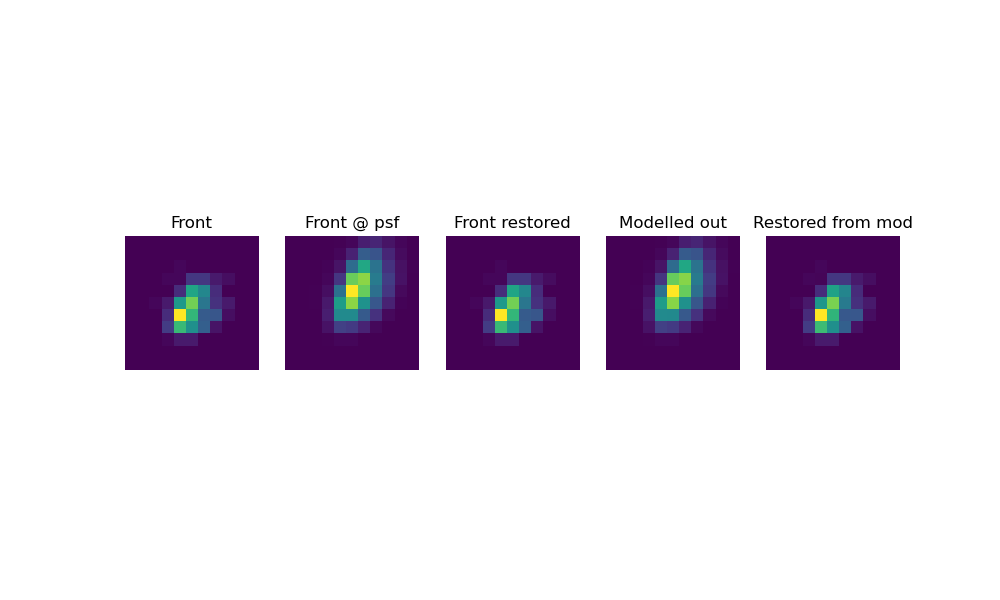

Corelation coefficient [[1.         0.99984628]
 [0.99984628 1.        ]]


In [55]:
convolve_and_deconvolve(pixel_array2, disp)

sum back pixels 122
sum recovered front 121.99999487430829
sum recovered back 121.99999487436529

Corelation coefficient [[1.       0.929787]
 [0.929787 1.      ]]


<IPython.core.display.Javascript object>


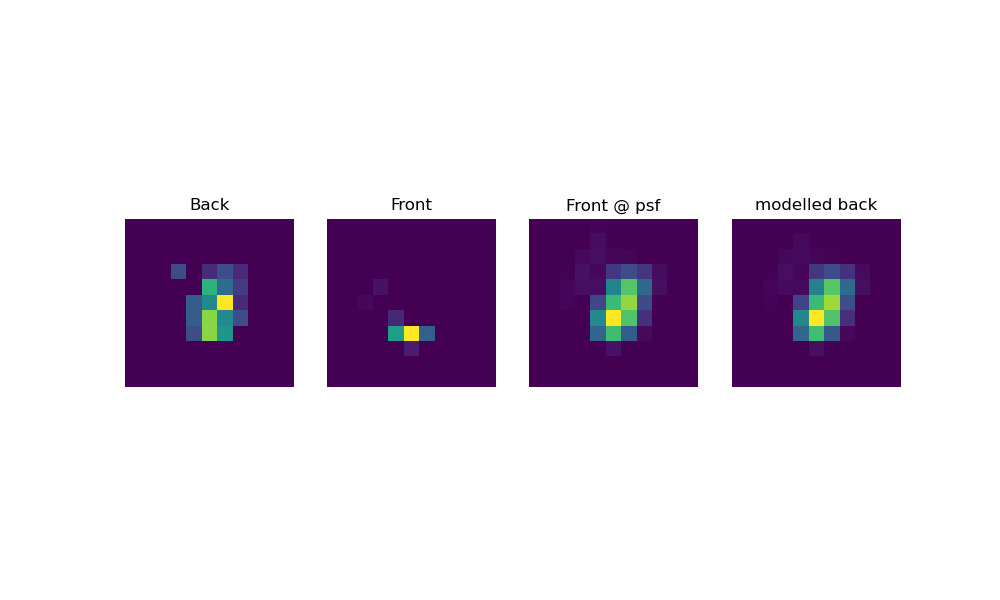

(-0.5, 10.5, 10.5, -0.5)

In [58]:
image = np.pad(pixel_array1,2)
print('sum back pixels', np.sum(image))

front1 = restoration.richardson_lucy(image, disp, num_iter= 50, clip=False, filter_epsilon=0.00)
recovered_back = conv2(front1, disp, 'full')[7:-7, 7:-7]
recovered_front = restoration.richardson_lucy(recovered_back, disp, num_iter= 50000, clip=False, filter_epsilon=0.00)
recovered_back2 = conv2(recovered_front, disp, 'full')[7:-7, 7:-7]

print('sum recovered front', np.sum(recovered_front))
print('sum recovered back', np.sum(recovered_back))
print()
print('Corelation coefficient', np.corrcoef(image.ravel(), recovered_back.ravel()))


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))

ax[0].imshow(np.pad(image, 0), cmap='viridis', interpolation='none')
ax[0].set_title('Back')
ax[0].axis('off')

ax[1].imshow(np.pad(front1, 0), cmap='viridis', interpolation='none')
ax[1].set_title('Front')
ax[1].axis('off')

ax[2].imshow(np.pad(recovered_back, 0), cmap='viridis', interpolation='none')
ax[2].set_title('Front @ psf')
ax[2].axis('off')

# ax[3].imshow(np.pad(recovered_front, 0), cmap='viridis', interpolation='none')
# ax[3].set_title('front')
# ax[3].axis('off')

ax[3].imshow(np.pad(counts1.T[2:-2, 2:-2], 0), cmap='viridis', interpolation='none')
ax[3].set_title('modelled back')
ax[3].axis('off')

sum normalised int 451
sum recovered front 450.9999999999081
sum recovered back 450.9999999999587

Corelation coefficient [[1.         0.98278103]
 [0.98278103 1.        ]]


<IPython.core.display.Javascript object>


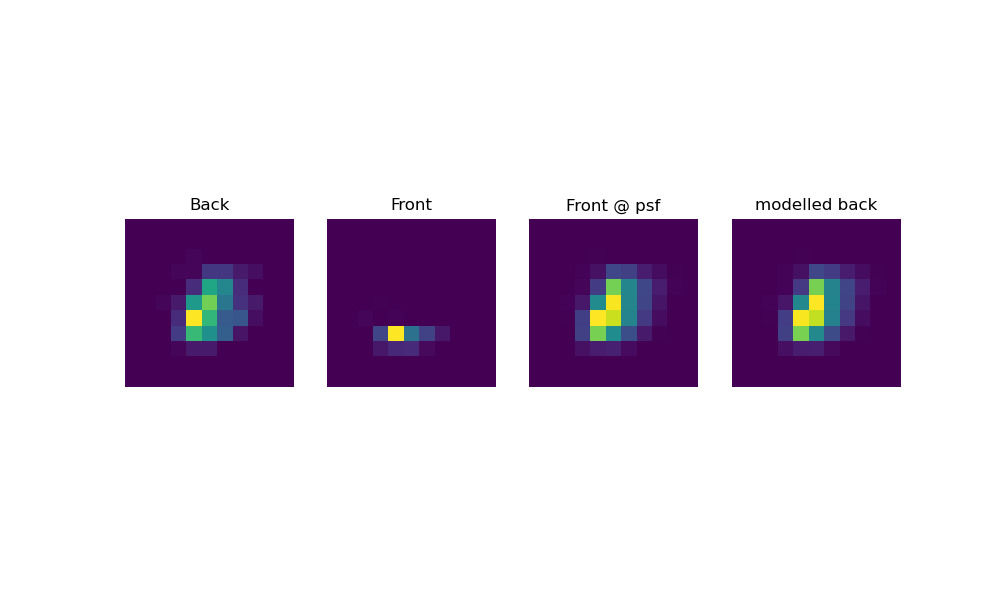

(-0.5, 10.5, 10.5, -0.5)

In [49]:
image = np.pad(pixel_array2,2)
print('sum normalised int', np.sum(image))

front2 = restoration.richardson_lucy(image, disp, num_iter= 50, clip=False, filter_epsilon=0.00)
recovered_back = conv2(front2, disp, 'full')[7:-7, 7:-7]
recovered_front = restoration.richardson_lucy(recovered_back, disp, num_iter= 50, clip=False, filter_epsilon=0.00)
recovered_back2 = conv2(recovered_front, disp, 'full')[7:-7, 7:-7]

print('sum recovered front', np.sum(recovered_front))
print('sum recovered back', np.sum(recovered_back))
print()
print('Corelation coefficient', np.corrcoef(image.ravel(), recovered_back.ravel()))


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))

ax[0].imshow(np.pad(image, 0), cmap='viridis', interpolation='none')
ax[0].set_title('Back')
ax[0].axis('off')

ax[1].imshow(np.pad(front2, 0), cmap='viridis', interpolation='none')
ax[1].set_title('Front')
ax[1].axis('off')

ax[2].imshow(np.pad(recovered_back, 0), cmap='viridis', interpolation='none')
ax[2].set_title('Front @ psf')
ax[2].axis('off')

# ax[3].imshow(np.pad(recovered_front, 0), cmap='viridis', interpolation='none')
# ax[3].set_title('front')
# ax[3].axis('off')

ax[3].imshow(np.pad(counts2.T[2:-2, 2:-2], 0), cmap='viridis', interpolation='none')
ax[3].set_title('modelled back')
ax[3].axis('off')

#ax[4].imshow(np.pad(recovered_back2, 0), interpolation='none')
#ax[4].set_title('back')

sum pixels back 87
sum recovered front 86.99999999994021
sum recovered back 86.99999999997699

Corelation coefficient [[1.         0.88528495]
 [0.88528495 1.        ]]


<IPython.core.display.Javascript object>


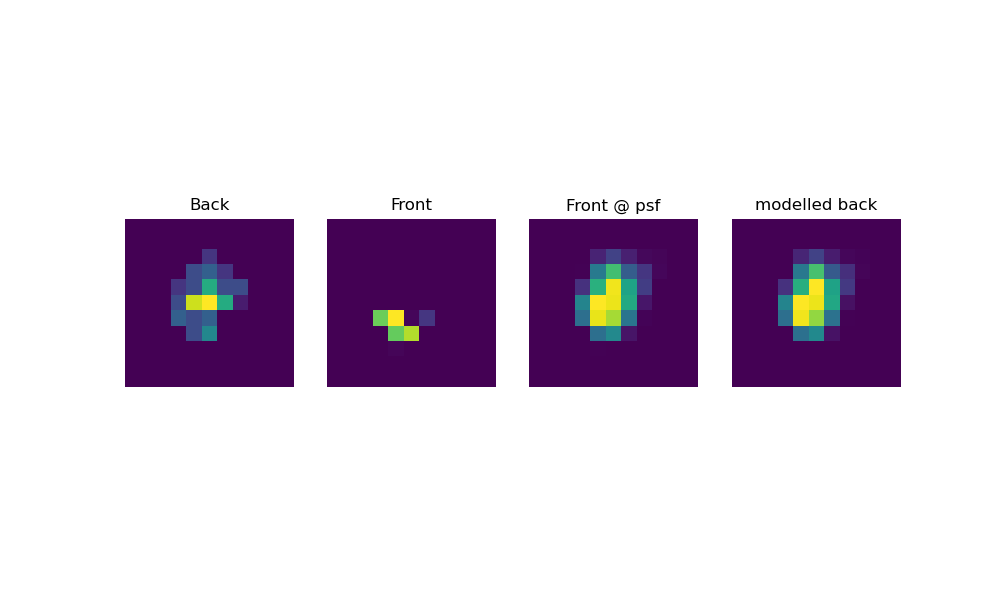

(-0.5, 10.5, 10.5, -0.5)

In [53]:
image = np.pad(pixel_array3,2)
print('sum pixels back', np.sum(image))

front3 = restoration.richardson_lucy(image, disp, num_iter= 50, clip=False, filter_epsilon=0.00)
recovered_back = conv2(front3, disp, 'full')[7:-7, 7:-7]
recovered_front = restoration.richardson_lucy(recovered_back, disp, num_iter= 50, clip=False, filter_epsilon=0.00)
recovered_back2 = conv2(recovered_front, disp, 'full')[7:-7, 7:-7]

print('sum recovered front', np.sum(recovered_front))
print('sum recovered back', np.sum(recovered_back))
print()
print('Corelation coefficient', np.corrcoef(image.ravel(), recovered_back.ravel()))


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))

ax[0].imshow(np.pad(image, 0), cmap='viridis', interpolation='none')
ax[0].set_title('Back')
ax[0].axis('off')

ax[1].imshow(np.pad(front3, 0), cmap='viridis', interpolation='none')
ax[1].set_title('Front')
ax[1].axis('off')

ax[2].imshow(np.pad(recovered_back, 0), cmap='viridis', interpolation='none')
ax[2].set_title('Front @ psf')
ax[2].axis('off')

# ax[3].imshow(np.pad(recovered_front, 0), cmap='viridis', interpolation='none')
# ax[3].set_title('front')
# ax[3].axis('off')

ax[3].imshow(np.pad(counts3.T[2:-2, 2:-2], 0), cmap='viridis', interpolation='none')
ax[3].set_title('modelled back')
ax[3].axis('off')

#ax[4].imshow(np.pad(recovered_back2, 0), interpolation='none')
#ax[4].set_title('back')

In [42]:
counts1, eff = project_probability(s1_vector1.swapaxes(0,1), front1[2:-2, 2:-2].astype(int), (px_x, px_y), padding, numMC,3)
print('efficiency', eff)

efficiency 0.5359256120527307


In [47]:
counts2, eff = project_probability(s1_vector2.swapaxes(0,1), front2[2:-2, 2:-2].astype(int), (px_x, px_y), padding, numMC,3)
print('efficiency', eff)

efficiency 0.5366113613613613


In [51]:
counts3, eff = project_probability(s1_vector3.swapaxes(0,1), front3[2:-2, 2:-2].astype(int), (px_x, px_y), padding, numMC,3)
print('efficiency', eff)

efficiency 0.5369047619047619
